**Nikolas Moustakidis**

**AEM: 3743**

**Support Vector Machine:**

The objective of the support vector machine algorithm is to find a hyperplane in an N-dimensional space (N — the number of features) that distinctly classifies the data points.

To separate the two classes of data points, there are many possible hyperplanes that could be chosen. Our objective is to find a plane that has the maximum margin, the maximum distance between data points of both classes. Maximizing the margin distance provides some reinforcement so that future data points can be classified with more confidence.

There are of course many different types of svm kernels, in this notebook I use three of them:

**Linear Kernel:**

It is the most basic type of kernel, usually one dimensional in nature. It proves to be the best function when there are lots of features. The linear kernel is mostly preferred for text-classification problems as most of these kinds of classification problems can be linearly separated, on the other hand it doesn't perform so well in image classification i.e. CIFAR dataset but usually is the fastest.

*   **Linear Kernel Formula:** F(x, xj) = sum( x.xj), where x, xj represents the data we are classifying.

**Polynomial Kernel:**

It is a more generalized representation of the linear kernel. Generally it is not as preferred as other kernel functions as it is less efficient and accurate

*   **Polynomial Kernel Formula:** F(x, xj) = (x.xj+1)^d, where ‘.’ shows the dot product of both the values, d denotes the degree and F(x, xj) representing the decision boundary to separate the given classes.

**Gaussian Radial Basis Function (RBF):**

 It is one of the most preferred and used kernel functions in svm. It is usually chosen for non-linear data. It helps to make proper separation when there is no prior knowledge of data.

*   **RBF Kernel Formula:** F(x, xj) = exp(-gamma * ||x - xj||^2), where the value of gamma varies from 0 to 1. You have to manually provide the value of gamma in the code. The most preferred value for gamma is 0.1


**Results and SVM comparison with KNN and Nearest Centroid**

As the results show in this notebook the SVM classifiers outperform by a small margin the KNN and NC classifiers **(SVM ~40% accuracy, KNN,NC-classifiers ~35% accuracy)**.


In [1]:
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from collections import Counter

import matplotlib.pyplot as plt
import urllib.request
import numpy as np
import tarfile
import pickle
import os

**Downloading the CIFAR-10 dataset**
*   Creating directory to store the batches of data
*   Downloading the CIFAR 10 dataset from the internet
*   Extracting the data from the downloaded compressed file

In [2]:
url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
download_dir = "./data"

dataset_name = url.split('/')[-1]
dataset_path = os.path.join(download_dir, dataset_name)

if not os.path.exists(dataset_path):
  if not os.path.exists(download_dir):
    os.makedirs(download_dir)

  print("Downloading dataset...")
  dataset_path, _ = urllib.request.urlretrieve(url=url, filename=dataset_path)

  print("Extracting files...")
  tarfile.open(name=dataset_path, mode="r:gz").extractall(download_dir)

  print('Done')
else:
  print("Dataset has already been downloaded and unpacked.")

Dataset has already been downloaded and unpacked.


**Loading the whole CIFAR dataset**
*   For the train set I appended all the training batches
*   X_train contains all the image data for training 
*   Y_train contains all the corresponding labels of the training image data
*   For the test set I used the test_batch
*   X_test contains all the image data for testing
*   Y_test contains all the corresponding labels of the testing image data

In [3]:
cifar10_dir = './data/cifar-10-batches-py'

X_train_list = []
Y_train_list = []

for batch in range(1,6):
  batch_file = os.path.join(cifar10_dir, 'data_batch_%d' % (batch, ))
  
  with open(batch_file, 'rb') as f:
    data_dict = pickle.load(f, encoding='latin1')

    X_batch = data_dict['data']
    Y_batch = data_dict['labels']
    X_batch = X_batch.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
    Y_batch = np.array(Y_batch)

  X_train_list.append(X_batch)
  Y_train_list.append(Y_batch)    

X_train = np.concatenate(X_train_list)
Y_train = np.concatenate(Y_train_list)

test_batch_path = os.path.join(cifar10_dir, 'test_batch')

with open(test_batch_path, 'rb') as f:
    data_dict = pickle.load(f, encoding='latin1')

    X_batch = data_dict['data']
    Y_batch = data_dict['labels']
    X_batch = X_batch.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
    Y_batch = np.array(Y_batch)

X_test = X_batch
Y_test = Y_batch

print('Succesfully loaded train and test data')
print('--------------------------------------')
print('X_train shape: ', X_train.shape)
print('Y_train shape: ', Y_train.shape)
print('X_test shape: ', X_test.shape)
print('Y_test shape: ', Y_test.shape)

Succesfully loaded train and test data
--------------------------------------
X_train shape:  (50000, 32, 32, 3)
Y_train shape:  (50000,)
X_test shape:  (10000, 32, 32, 3)
Y_test shape:  (10000,)


**Making sure my dataset is balanced along the 10 classes (0 to 9 where zero is equal to plane and 9 is equal to truck, and so on so forth)**

In [4]:
train_occurences = Counter(Y_train)
test_occurences = Counter(Y_test)

print(train_occurences)
print(test_occurences)

Counter({6: 5000, 9: 5000, 4: 5000, 1: 5000, 2: 5000, 7: 5000, 8: 5000, 3: 5000, 5: 5000, 0: 5000})
Counter({3: 1000, 8: 1000, 0: 1000, 6: 1000, 1: 1000, 9: 1000, 5: 1000, 7: 1000, 4: 1000, 2: 1000})


**Visualizing a few random dataset samples from each class**

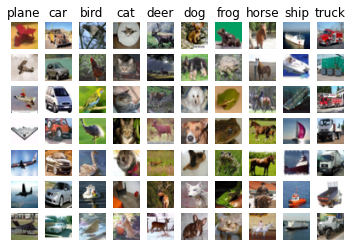

In [5]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

num_classes = len(classes)
samples_per_class = 7
for cls_index, cls in enumerate(classes):
  idxs = np.flatnonzero(Y_train == cls_index)
  idxs = np.random.choice(idxs, samples_per_class, replace=False)
  for i, idx in enumerate(idxs):
    plt_idx = i * num_classes + cls_index + 1
    plt.subplot(samples_per_class, num_classes, plt_idx)
    plt.imshow(X_train[idx].astype('uint8'))
    plt.axis('off')
    if i == 0:
      plt.title(cls)
plt.show()

**Subset of Dataset vs Whole Dataset:**

As expected training on a smaller amount of data had a negative impact in the overall performace of the SVM classifiers. That doesn't mean that always more data means better results because this could result in overfitting where basically the model cannot generalize and fits too closely to the training dataset instead

**Shuffling vs No Shuffling:**

On the other hand, shuffling didn't affect the results in neither of the three classifiers

In [6]:
train_test_on_subset = True
shuffle_train_data = False

if train_test_on_subset:
  num_training = 1000
  num_test = 100
else:
  num_training = len(X_train)
  num_test = len(X_test)

if shuffle_train_data:
  train_mask = np.random.permutation(num_training)
else:
  train_mask = np.arange(num_training)

X_train = X_train[train_mask]
Y_train = Y_train[train_mask]

test_mask = np.arange(num_test)

X_test = X_test[test_mask]
Y_test = Y_test[test_mask]

print('X_train shape: ', X_train.shape)
print('Y_train shape: ', Y_train.shape)
print('X_test shape: ', X_test.shape)
print('Y_test shape: ', Y_test.shape)

X_train shape:  (1000, 32, 32, 3)
Y_train shape:  (1000,)
X_test shape:  (100, 32, 32, 3)
Y_test shape:  (100,)


Formating the data appropriately in order to feed them in the classifier

**[N_Samples, Height, Width, Channels] -> [N_Samples, N_Features]**

In [7]:
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)

X_train shape:  (1000, 3072)
X_test shape:  (100, 3072)


**Using Principal Component Analysis (PCA) for dimensionality reduction**

In [8]:
pca = False

if pca:
  combined=np.vstack((X_train,X_test))

  pca = PCA().fit(combined)
  plt.plot(np.cumsum(pca.explained_variance_ratio_))
  plt.xlabel('number of components')
  plt.ylabel('cumulative explained variance')

  print('Variance retained from 150 components', pca.explained_variance_ratio_.cumsum()[149])
  print('Variance retained from 500 components', pca.explained_variance_ratio_.cumsum()[499])

  # Reduce dimensions, project from 3072 to 500 or 150 dimensions
  pca = PCA(n_components=500)
  pca.fit(combined)
  projected = pca.transform(combined)

  X_train=projected[:1000,:]
  X_test=projected[1000:,:]

  print('X_train shape: ', X_train.shape)
  print('Y_train shape: ', Y_train.shape)
  print('X_test shape: ', X_test.shape)
  print('Y_test shape: ', Y_test.shape)

**Defining the training and testing functions, the three different SVM kernels and helper functions to print and plot the classification performance**

In [9]:
def svm_linear(c):
  svc = svm.SVC(probability = False, kernel = 'linear', C = c)
  
  # Fit the classifier on the training set.
  svc.fit(X_train, Y_train)
  
  print('Results for c = ', c)

  # Find the prediction and accuracy on the training set.
  y_lin_train_pred = svc.predict(X_train)
  acc_train = np.mean(y_lin_train_pred == Y_train)
  acc_train_svm_linear.append(acc_train)
  print('Train Accuracy = {0:f}'.format(acc_train))
  
  # Find the prediction and accuracy on the test set.
  y_lin_test_pred = svc.predict(X_test)
  acc_test = np.mean(y_lin_test_pred == Y_test)
  acc_test_svm_linear.append(acc_test)
  print('Test Accuracy = {0:f}\n'.format(acc_test))

  print_performance(y_lin_test_pred, Y_test)
  
def svm_polynomial(c):
  svc_polynomial = svm.SVC(probability = False, kernel = 'poly', C = c)
  
  # Fit the classifier on the training set.
  svc_polynomial.fit(X_train, Y_train)

  print('Results for c = ', c)
  
  # Find the prediction and accuracy on the training set.
  y_poly_train_pred = svc_polynomial.predict(X_train)
  acc_train = np.mean(y_poly_train_pred == Y_train)
  acc_train_svm_poly.append(acc_train)
  print('Train Accuracy = {0:f}'.format(acc_train))
  
  # Find the prediction and accuracy on the test set.
  y_poly_test_pred = svc_polynomial.predict(X_test)
  acc_test = np.mean(y_poly_test_pred == Y_test)
  acc_test_svm_poly.append(acc_test)
  print('Test Accuracy = {0:f}\n'.format(acc_test))

  print_performance(y_poly_test_pred, Y_test)

def svm_rbf(c, g):
  svc_rbf = svm.SVC(probability = False, kernel = 'rbf', C = c, gamma = g)

  # Fit the classifier on the training set.
  svc_rbf.fit(X_train, Y_train)

  print('Results for c = ', c)

  # Find the prediction and accuracy on the training set.
  y_rbf_train_pred = svc_rbf.predict(X_train)
  acc = np.mean(y_rbf_train_pred == Y_train)
  print('Train Accuracy = {0:f}'.format(acc))
  acc_train_svm_rbf.append(acc)

  # Find the prediction and accuracy on the test set.
  y_rbf_test_pred = svc_rbf.predict(X_test)
  acc = np.mean(y_rbf_test_pred == Y_test)
  acc_test_svm_rbf.append(acc)
  print('Test Accuracy = {0:f}\n'.format(acc))

  print_performance(y_rbf_test_pred, Y_test)

def print_performance(y_pred, y_gt):
  conf_matrix = confusion_matrix(y_gt, y_pred)
  print('Confusion Matrix:\n', conf_matrix)
  print('Performace metrics:\n', classification_report(y_gt, y_pred, target_names=classes))

def plot_performace(c_svm, acc_train_svm, acc_test_svm):
  plt.plot(c_svm, acc_train_svm,'.-',color='red')
  plt.plot(c_svm, acc_test_svm,'.-',color='orange')
  plt.xlabel('c')
  plt.ylabel('Accuracy')
  plt.title("Train and Test Accuracy for different regularization parameter")
  plt.grid()

**Training and testing the Linear SVM classifier with different values of c (regularization parameter) and printing the performance metrics**


Results for c =  0.0001
Train Accuracy = 1.000000
Test Accuracy = 0.350000

Confusion Matrix:
 [[6 0 0 1 0 1 0 0 1 1]
 [0 2 1 1 0 0 1 0 0 1]
 [2 0 2 0 0 1 2 0 1 0]
 [0 0 3 2 1 1 2 0 0 1]
 [2 0 0 3 2 0 0 0 0 0]
 [1 1 0 1 1 3 0 1 0 0]
 [0 0 3 1 5 0 5 2 0 0]
 [1 1 1 2 1 1 0 1 2 1]
 [3 2 0 0 0 0 0 0 8 0]
 [1 3 1 1 0 0 0 1 0 4]]
Performace metrics:
               precision    recall  f1-score   support

       plane       0.38      0.60      0.46        10
         car       0.22      0.33      0.27         6
        bird       0.18      0.25      0.21         8
         cat       0.17      0.20      0.18        10
        deer       0.20      0.29      0.24         7
         dog       0.43      0.38      0.40         8
        frog       0.50      0.31      0.38        16
       horse       0.20      0.09      0.13        11
        ship       0.67      0.62      0.64        13
       truck       0.50      0.36      0.42        11

    accuracy                           0.35       100
   

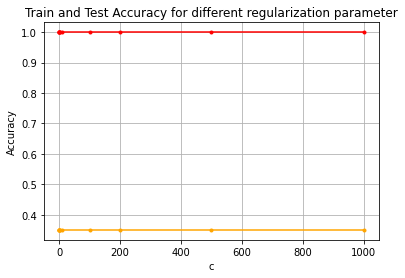

In [10]:
acc_train_svm_linear = []
acc_test_svm_linear = []
c_svm_linear = [0.0001,0.001,0.01,0.1,1,10,100,200,500,1000]

for c in c_svm_linear:
    svm_linear(c)

plot_performace(c_svm_linear, acc_train_svm_linear, acc_test_svm_linear)

**Training and testing the Polynomial SVM classifier with different values of c (regularization parameter) and printing the performance metrics**

Results for c =  0.0001
Train Accuracy = 0.128000
Test Accuracy = 0.080000

Confusion Matrix:
 [[ 2  8  0  0  0  0  0  0  0  0]
 [ 0  6  0  0  0  0  0  0  0  0]
 [ 1  7  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0  7  0  0  0  0  0  0  0  0]
 [ 0  8  0  0  0  0  0  0  0  0]
 [ 0 16  0  0  0  0  0  0  0  0]
 [ 1 10  0  0  0  0  0  0  0  0]
 [ 2 11  0  0  0  0  0  0  0  0]
 [ 0 11  0  0  0  0  0  0  0  0]]
Performace metrics:
               precision    recall  f1-score   support

       plane       0.33      0.20      0.25        10
         car       0.06      1.00      0.12         6
        bird       0.00      0.00      0.00         8
         cat       0.00      0.00      0.00        10
        deer       0.00      0.00      0.00         7
         dog       0.00      0.00      0.00         8
        frog       0.00      0.00      0.00        16
       horse       0.00      0.00      0.00        11
        ship       0.00      0.00      0.00        13
       truck

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results for c =  0.001
Train Accuracy = 0.226000
Test Accuracy = 0.240000

Confusion Matrix:
 [[ 2  4  0  0  0  0  1  0  1  2]
 [ 0  0  0  0  0  0  4  0  1  1]
 [ 3  0  0  0  0  0  5  0  0  0]
 [ 0  0  1  0  0  0  8  0  0  1]
 [ 0  2  0  0  0  0  5  0  0  0]
 [ 0  1  0  0  0  0  7  0  0  0]
 [ 0  0  0  0  0  0 16  0  0  0]
 [ 1  1  0  0  0  0  7  0  1  1]
 [ 1  3  0  0  0  0  2  0  6  1]
 [ 0  5  0  0  0  0  5  0  1  0]]
Performace metrics:
               precision    recall  f1-score   support

       plane       0.29      0.20      0.24        10
         car       0.00      0.00      0.00         6
        bird       0.00      0.00      0.00         8
         cat       0.00      0.00      0.00        10
        deer       0.00      0.00      0.00         7
         dog       0.00      0.00      0.00         8
        frog       0.27      1.00      0.42        16
       horse       0.00      0.00      0.00        11
        ship       0.60      0.46      0.52        13
       truck 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results for c =  0.01
Train Accuracy = 0.430000
Test Accuracy = 0.360000

Confusion Matrix:
 [[ 3  0  0  0  0  0  1  1  4  1]
 [ 0  2  0  0  0  0  3  0  0  1]
 [ 1  0  1  0  0  0  5  0  1  0]
 [ 0  0  1  0  0  1  7  0  0  1]
 [ 1  1  0  0  0  0  5  0  0  0]
 [ 0  0  2  0  0  2  3  1  0  0]
 [ 0  0  0  1  1  0 14  0  0  0]
 [ 1  0  0  0  2  0  5  0  1  2]
 [ 2  2  0  0  0  0  0  0  8  1]
 [ 0  2  0  0  0  0  2  0  1  6]]
Performace metrics:
               precision    recall  f1-score   support

       plane       0.38      0.30      0.33        10
         car       0.29      0.33      0.31         6
        bird       0.25      0.12      0.17         8
         cat       0.00      0.00      0.00        10
        deer       0.00      0.00      0.00         7
         dog       0.67      0.25      0.36         8
        frog       0.31      0.88      0.46        16
       horse       0.00      0.00      0.00        11
        ship       0.53      0.62      0.57        13
       truck  

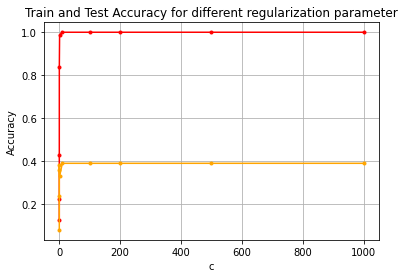

In [11]:
acc_train_svm_poly = []
acc_test_svm_poly = []
c_svm_poly = [0.0001,0.001,0.01,0.1,1,10,100,200,500,1000]

for c in c_svm_poly:
    svm_polynomial(c)

plot_performace(c_svm_poly, acc_train_svm_poly, acc_test_svm_poly)

**Training and testing the RBF SVM classifier with different values of c (regularization parameter) and printing the performance metrics**

Results for c =  0.0001
Train Accuracy = 0.112000
Test Accuracy = 0.060000

Confusion Matrix:
 [[ 0 10  0  0  0  0  0  0  0  0]
 [ 0  6  0  0  0  0  0  0  0  0]
 [ 0  8  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0  7  0  0  0  0  0  0  0  0]
 [ 0  8  0  0  0  0  0  0  0  0]
 [ 0 16  0  0  0  0  0  0  0  0]
 [ 0 11  0  0  0  0  0  0  0  0]
 [ 0 13  0  0  0  0  0  0  0  0]
 [ 0 11  0  0  0  0  0  0  0  0]]
Performace metrics:
               precision    recall  f1-score   support

       plane       0.00      0.00      0.00        10
         car       0.06      1.00      0.11         6
        bird       0.00      0.00      0.00         8
         cat       0.00      0.00      0.00        10
        deer       0.00      0.00      0.00         7
         dog       0.00      0.00      0.00         8
        frog       0.00      0.00      0.00        16
       horse       0.00      0.00      0.00        11
        ship       0.00      0.00      0.00        13
       truck

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results for c =  0.001
Train Accuracy = 0.112000
Test Accuracy = 0.060000

Confusion Matrix:
 [[ 0 10  0  0  0  0  0  0  0  0]
 [ 0  6  0  0  0  0  0  0  0  0]
 [ 0  8  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0  7  0  0  0  0  0  0  0  0]
 [ 0  8  0  0  0  0  0  0  0  0]
 [ 0 16  0  0  0  0  0  0  0  0]
 [ 0 11  0  0  0  0  0  0  0  0]
 [ 0 13  0  0  0  0  0  0  0  0]
 [ 0 11  0  0  0  0  0  0  0  0]]
Performace metrics:
               precision    recall  f1-score   support

       plane       0.00      0.00      0.00        10
         car       0.06      1.00      0.11         6
        bird       0.00      0.00      0.00         8
         cat       0.00      0.00      0.00        10
        deer       0.00      0.00      0.00         7
         dog       0.00      0.00      0.00         8
        frog       0.00      0.00      0.00        16
       horse       0.00      0.00      0.00        11
        ship       0.00      0.00      0.00        13
       truck 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results for c =  0.01
Train Accuracy = 0.112000
Test Accuracy = 0.060000

Confusion Matrix:
 [[ 0 10  0  0  0  0  0  0  0  0]
 [ 0  6  0  0  0  0  0  0  0  0]
 [ 0  8  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0  7  0  0  0  0  0  0  0  0]
 [ 0  8  0  0  0  0  0  0  0  0]
 [ 0 16  0  0  0  0  0  0  0  0]
 [ 0 11  0  0  0  0  0  0  0  0]
 [ 0 13  0  0  0  0  0  0  0  0]
 [ 0 11  0  0  0  0  0  0  0  0]]
Performace metrics:
               precision    recall  f1-score   support

       plane       0.00      0.00      0.00        10
         car       0.06      1.00      0.11         6
        bird       0.00      0.00      0.00         8
         cat       0.00      0.00      0.00        10
        deer       0.00      0.00      0.00         7
         dog       0.00      0.00      0.00         8
        frog       0.00      0.00      0.00        16
       horse       0.00      0.00      0.00        11
        ship       0.00      0.00      0.00        13
       truck  

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results for c =  0.1
Train Accuracy = 0.112000
Test Accuracy = 0.060000

Confusion Matrix:
 [[ 0 10  0  0  0  0  0  0  0  0]
 [ 0  6  0  0  0  0  0  0  0  0]
 [ 0  8  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0  7  0  0  0  0  0  0  0  0]
 [ 0  8  0  0  0  0  0  0  0  0]
 [ 0 16  0  0  0  0  0  0  0  0]
 [ 0 11  0  0  0  0  0  0  0  0]
 [ 0 13  0  0  0  0  0  0  0  0]
 [ 0 11  0  0  0  0  0  0  0  0]]
Performace metrics:
               precision    recall  f1-score   support

       plane       0.00      0.00      0.00        10
         car       0.06      1.00      0.11         6
        bird       0.00      0.00      0.00         8
         cat       0.00      0.00      0.00        10
        deer       0.00      0.00      0.00         7
         dog       0.00      0.00      0.00         8
        frog       0.00      0.00      0.00        16
       horse       0.00      0.00      0.00        11
        ship       0.00      0.00      0.00        13
       truck   

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results for c =  1
Train Accuracy = 1.000000
Test Accuracy = 0.060000

Confusion Matrix:
 [[ 0 10  0  0  0  0  0  0  0  0]
 [ 0  6  0  0  0  0  0  0  0  0]
 [ 0  8  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0  7  0  0  0  0  0  0  0  0]
 [ 0  8  0  0  0  0  0  0  0  0]
 [ 0 16  0  0  0  0  0  0  0  0]
 [ 0 11  0  0  0  0  0  0  0  0]
 [ 0 13  0  0  0  0  0  0  0  0]
 [ 0 11  0  0  0  0  0  0  0  0]]
Performace metrics:
               precision    recall  f1-score   support

       plane       0.00      0.00      0.00        10
         car       0.06      1.00      0.11         6
        bird       0.00      0.00      0.00         8
         cat       0.00      0.00      0.00        10
        deer       0.00      0.00      0.00         7
         dog       0.00      0.00      0.00         8
        frog       0.00      0.00      0.00        16
       horse       0.00      0.00      0.00        11
        ship       0.00      0.00      0.00        13
       truck     

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results for c =  10
Train Accuracy = 1.000000
Test Accuracy = 0.060000

Confusion Matrix:
 [[ 0 10  0  0  0  0  0  0  0  0]
 [ 0  6  0  0  0  0  0  0  0  0]
 [ 0  8  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0  7  0  0  0  0  0  0  0  0]
 [ 0  8  0  0  0  0  0  0  0  0]
 [ 0 16  0  0  0  0  0  0  0  0]
 [ 0 11  0  0  0  0  0  0  0  0]
 [ 0 13  0  0  0  0  0  0  0  0]
 [ 0 11  0  0  0  0  0  0  0  0]]
Performace metrics:
               precision    recall  f1-score   support

       plane       0.00      0.00      0.00        10
         car       0.06      1.00      0.11         6
        bird       0.00      0.00      0.00         8
         cat       0.00      0.00      0.00        10
        deer       0.00      0.00      0.00         7
         dog       0.00      0.00      0.00         8
        frog       0.00      0.00      0.00        16
       horse       0.00      0.00      0.00        11
        ship       0.00      0.00      0.00        13
       truck    

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results for c =  100
Train Accuracy = 1.000000
Test Accuracy = 0.060000

Confusion Matrix:
 [[ 0 10  0  0  0  0  0  0  0  0]
 [ 0  6  0  0  0  0  0  0  0  0]
 [ 0  8  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0  7  0  0  0  0  0  0  0  0]
 [ 0  8  0  0  0  0  0  0  0  0]
 [ 0 16  0  0  0  0  0  0  0  0]
 [ 0 11  0  0  0  0  0  0  0  0]
 [ 0 13  0  0  0  0  0  0  0  0]
 [ 0 11  0  0  0  0  0  0  0  0]]
Performace metrics:
               precision    recall  f1-score   support

       plane       0.00      0.00      0.00        10
         car       0.06      1.00      0.11         6
        bird       0.00      0.00      0.00         8
         cat       0.00      0.00      0.00        10
        deer       0.00      0.00      0.00         7
         dog       0.00      0.00      0.00         8
        frog       0.00      0.00      0.00        16
       horse       0.00      0.00      0.00        11
        ship       0.00      0.00      0.00        13
       truck   

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results for c =  200
Train Accuracy = 1.000000
Test Accuracy = 0.060000

Confusion Matrix:
 [[ 0 10  0  0  0  0  0  0  0  0]
 [ 0  6  0  0  0  0  0  0  0  0]
 [ 0  8  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0  7  0  0  0  0  0  0  0  0]
 [ 0  8  0  0  0  0  0  0  0  0]
 [ 0 16  0  0  0  0  0  0  0  0]
 [ 0 11  0  0  0  0  0  0  0  0]
 [ 0 13  0  0  0  0  0  0  0  0]
 [ 0 11  0  0  0  0  0  0  0  0]]
Performace metrics:
               precision    recall  f1-score   support

       plane       0.00      0.00      0.00        10
         car       0.06      1.00      0.11         6
        bird       0.00      0.00      0.00         8
         cat       0.00      0.00      0.00        10
        deer       0.00      0.00      0.00         7
         dog       0.00      0.00      0.00         8
        frog       0.00      0.00      0.00        16
       horse       0.00      0.00      0.00        11
        ship       0.00      0.00      0.00        13
       truck   

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results for c =  500
Train Accuracy = 1.000000
Test Accuracy = 0.060000

Confusion Matrix:
 [[ 0 10  0  0  0  0  0  0  0  0]
 [ 0  6  0  0  0  0  0  0  0  0]
 [ 0  8  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0  7  0  0  0  0  0  0  0  0]
 [ 0  8  0  0  0  0  0  0  0  0]
 [ 0 16  0  0  0  0  0  0  0  0]
 [ 0 11  0  0  0  0  0  0  0  0]
 [ 0 13  0  0  0  0  0  0  0  0]
 [ 0 11  0  0  0  0  0  0  0  0]]
Performace metrics:
               precision    recall  f1-score   support

       plane       0.00      0.00      0.00        10
         car       0.06      1.00      0.11         6
        bird       0.00      0.00      0.00         8
         cat       0.00      0.00      0.00        10
        deer       0.00      0.00      0.00         7
         dog       0.00      0.00      0.00         8
        frog       0.00      0.00      0.00        16
       horse       0.00      0.00      0.00        11
        ship       0.00      0.00      0.00        13
       truck   

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results for c =  1000
Train Accuracy = 1.000000
Test Accuracy = 0.060000

Confusion Matrix:
 [[ 0 10  0  0  0  0  0  0  0  0]
 [ 0  6  0  0  0  0  0  0  0  0]
 [ 0  8  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0  7  0  0  0  0  0  0  0  0]
 [ 0  8  0  0  0  0  0  0  0  0]
 [ 0 16  0  0  0  0  0  0  0  0]
 [ 0 11  0  0  0  0  0  0  0  0]
 [ 0 13  0  0  0  0  0  0  0  0]
 [ 0 11  0  0  0  0  0  0  0  0]]
Performace metrics:
               precision    recall  f1-score   support

       plane       0.00      0.00      0.00        10
         car       0.06      1.00      0.11         6
        bird       0.00      0.00      0.00         8
         cat       0.00      0.00      0.00        10
        deer       0.00      0.00      0.00         7
         dog       0.00      0.00      0.00         8
        frog       0.00      0.00      0.00        16
       horse       0.00      0.00      0.00        11
        ship       0.00      0.00      0.00        13
       truck  

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


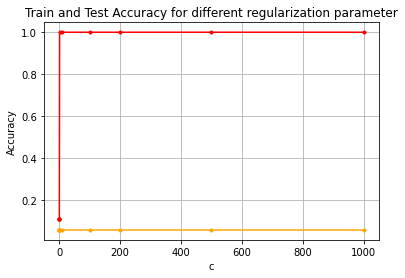

In [12]:
acc_train_svm_rbf= []
acc_test_svm_rbf = []
c_svm_rbf = [0.0001,0.001,0.01,0.1,1,10,100,200,500,1000]

for c in c_svm_rbf:
     svm_rbf(c, 'auto')

plot_performace(c_svm_rbf, acc_train_svm_rbf, acc_test_svm_rbf)

**Final Thoughts**

In this notebook I only used a small proportion of the dataset to train because otherwise the training took way too much time to finish. Using a few more data points could boost the performance of the SVM maybe a bit over 40% in accuracy.

In comparison to the case without using dimensionality reduction, PCA in an already small dataset didn't improve the accuracy on the test set from 39% (3072 dimensions) but actually dropped it to 35% (500 dimensions) and 34% (150 dimensions). However, notice that the optimal kernel in the case of PCA is the linear kernel in contrast to the polynomial kernel used earlier without dimensionality reduction. This is because the 150 and 500 components are in a different coordinate system that is better modelled by the linear kernel.

Comparing the performance of the SVM Classifiers using PCA in a larger proportion of the dataset could actually boost the accuracy and lower the training time a lot compared to training without dimensionality reduction.

**Best Results**

* Without PCA, 3072 components, 1000 train data points:
  * Best classifier: Polynomial
  * Best regularization parameter: c >= 10
  * Best test accuracy: 39%

* PCA, 150 components, 1000 train data points:
  * Best classifier: Linear
  * Best regularization parameter: c anything
  * Best test accuracy: 34%

* PCA, 500 components, 1000 train data points:
  * Best classifier: Linear
  * Best regularization parameter: c anything
  * Best test accuracy: 35%





